In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from pde_solvers.BurgerSolver import get_burger_solver
from EquationModel import InducedRKHS

  0%|          | 0/2019 [00:00<?, ?it/s]

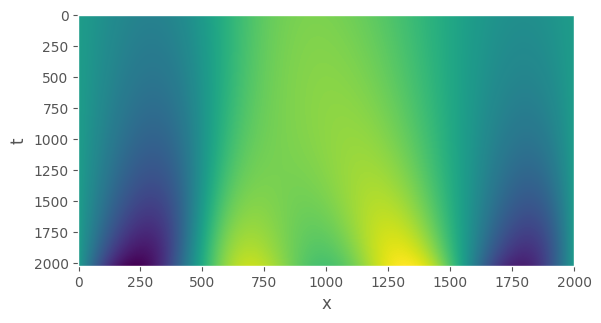

In [2]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0 = func_u0(grid)[1:-1]

sols,tvals = solver(u0,1.01)
sols = np.hstack([np.zeros((len(sols),1)),sols,np.zeros((len(sols),1))])
plt.imshow(sols[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)

In [3]:
interp = RectBivariateSpline(tvals,grid,sols)
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    ut_interp = interp.partial_derivative(1,0)
    return ut_interp(x[:,0],x[:,1],grid = False)

In [4]:
def build_tx_grid(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

def build_tx_grid_chebyshev(t_range,x_range,num_grid_t,num_grid_x,alpha = 0.5):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    nodes = jnp.cos(jnp.pi*(2*jnp.arange(0,num_grid_x,1)[::-1])/(2*(num_grid_x-1)))
    reg_grid = jnp.linspace(-1,1,num_grid_x)
    nodes = alpha * nodes + (1-alpha) * reg_grid
    # nodes = jnp.sign(nodes)*jnp.abs(nodes)**(5/4)
    full_x_grid = (nodes  + (x_range[0]+1))/(2*(x_range[1]-x_range[0]))
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary


In [5]:
num_grid_x = 31
num_grid_t = 26

tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.1)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)


u_true = u_true_function(tx_all)

num_obs = 40
np.random.seed(40)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)

x_t_sample_inds = np.random.choice(remaining_inds,num_obs,replace = False)
x_t_sample_inds = jnp.hstack([init_obs_inds,x_t_sample_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)

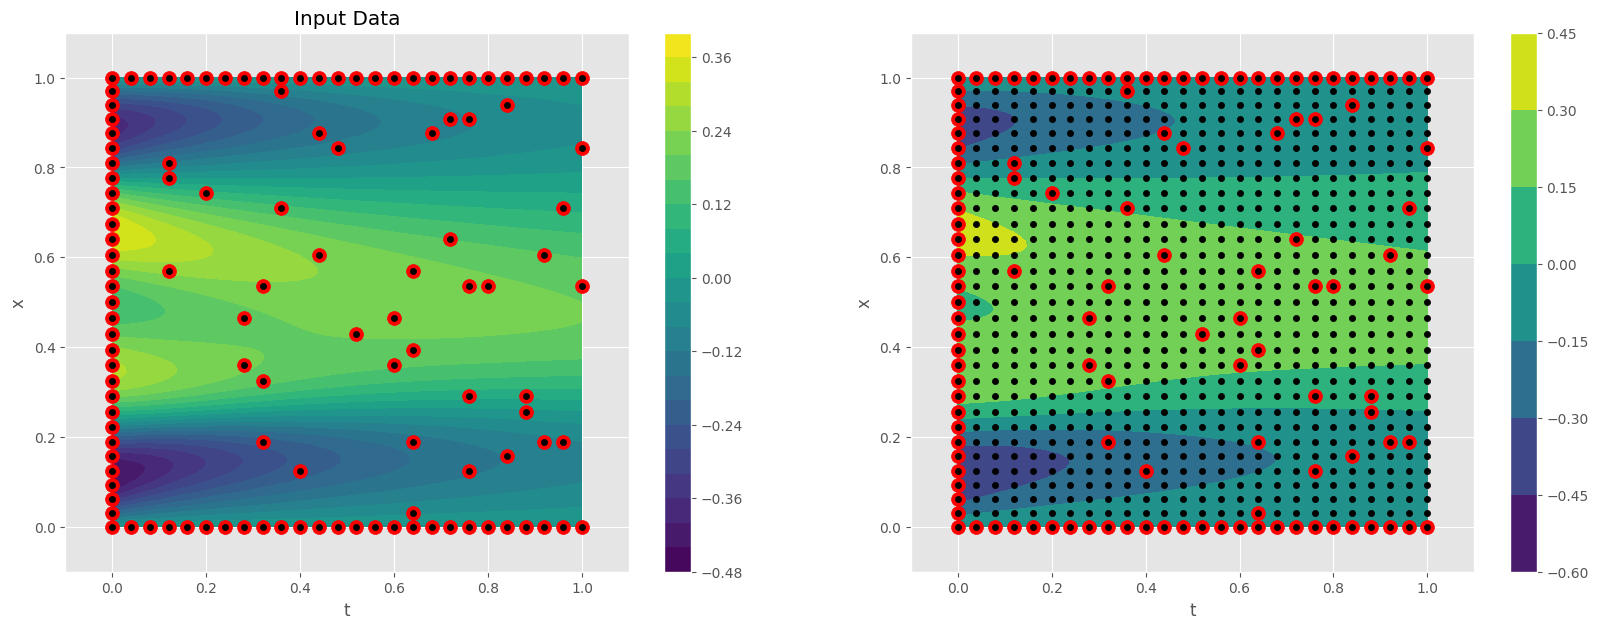

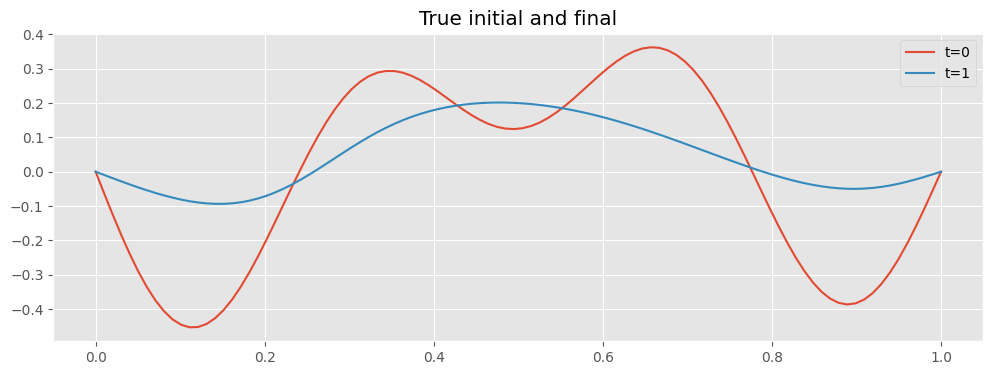

In [6]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title("Input Data")
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine))
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)

plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()
plt.figure(figsize=(12,4))
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,100)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(100),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(100),grid_points]).T),label = 't=1')
plt.legend()
plt.show()

In [47]:
from Kernels import get_anisotropic_gaussianRBF

def log1pexp(x):
    return jnp.log(jnp.exp(-x)+1) + x
def inv_log1pexp(y):
    return jnp.log(jnp.exp(y)-1)

def marginal_like(lengthscales):
    A = jnp.diag(lengthscales)
    kfunc = vectorize_kfunc(get_anisotropic_gaussianRBF(1.,A))
    K = kfunc(tx_obs,tx_obs)
    K = K + 1e-7 * diagpart(K)
    return (1/2) * u_obs.T@jnp.linalg.inv(K)@u_obs + (1/2) * jnp.linalg.slogdet(K).logabsdet

@jax.jit
@jax.value_and_grad
def loss(kernel_params):
    return marginal_like(log1pexp(kernel_params))

init_kp = jnp.array([200.,200.])
from jax import value_and_grad
from jaxopt import LBFGS,GradientDescent

solver = LBFGS(loss,value_and_grad=True,history_size = 5,jit = True)
#solver = GradientDescent(loss,value_and_grad=True,jit = False,tol = 1e-5)

result = solver.run(init_kp)
ML_lengthscales = log1pexp(result.params)
sol = result.params
ML_lengthscales = log1pexp(sol)
print(1/(jnp.sqrt(ML_lengthscales)))

[0.0708015  0.07077659]


In [48]:
loss(result.params)

(Array(-167.15875931, dtype=float64),
 Array([0.51528629, 0.37315891], dtype=float64))

In [55]:
scales = jnp.logspace(-1.2,1.2,50)
values = jax.vmap(marginal_like)(scales.reshape(-1,1)*log1pexp(result.params))

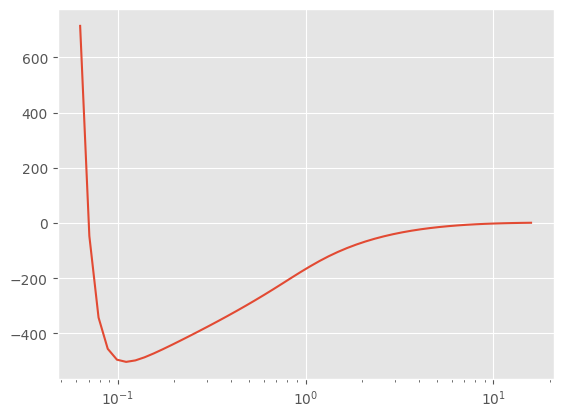

In [56]:
plt.plot(scales,values)
plt.xscale('log')

In [21]:
loss(result.params)

(Array(-580.62323852, dtype=float64),
 Array([-3.34517833e-05, -2.88815104e-04], dtype=float64))

In [13]:
ML_lengthscales

Array([nan, nan], dtype=float64)

In [327]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from EquationModel import CholInducedRKHS, OperatorPDEModel

u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

k_u = get_anisotropic_gaussianRBF(2.,jnp.diag(ML_lengthscales))

u_model = CholInducedRKHS(
    tx_all,
    feature_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )
    num_params = len(grid_features_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

In [328]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(P_model.num_params)])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-9,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4
)


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.003075, Jres = 33.45, alpha = 0.08333, improvement_ratio = 0.9867
Iteration 1, loss = 0.001253, Jres = 5.935, alpha = 0.06944, improvement_ratio = 1.004
Iteration 2, loss = 0.0007997, Jres = 0.6673, alpha = 0.05787, improvement_ratio = 1.003
Iteration 3, loss = 0.0005794, Jres = 0.1118, alpha = 0.04823, improvement_ratio = 0.9996
Iteration 4, loss = 0.0004478, Jres = 0.06044, alpha = 0.04019, improvement_ratio = 0.9985
Iteration 5, loss = 0.0003604, Jres = 0.0453, alpha = 0.03349, improvement_ratio = 0.9981
Iteration 50, loss = 3.283e-06, Jres = 0.001493, alpha = 9.157e-06, improvement_ratio = 0.9987
Iteration 100, loss = 4.378e-07, Jres = 6.51e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 150, loss = 3.283e-07, Jres = 1.709e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 2.876e-07, Jres = 1.009e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 250, loss = 2.671e-07, Jres = 6.851e-08, alpha = 8.333e-07, improvement_ratio =

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1730180/4099462765.py:3: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([loss_vals,refinement_losses]))


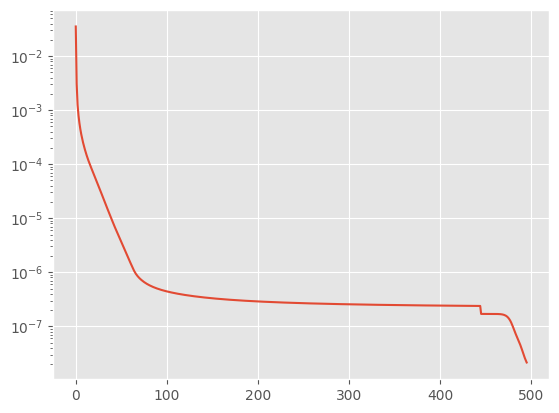

In [329]:
from LM_Solve import adaptive_refine_solution
p_adjusted,refinement_losses,reg_vals = adaptive_refine_solution(params,EqnModel,1e-3,50)
plt.plot(jnp.hstack([loss_vals,refinement_losses]))
plt.yscale('log')
plt.show()

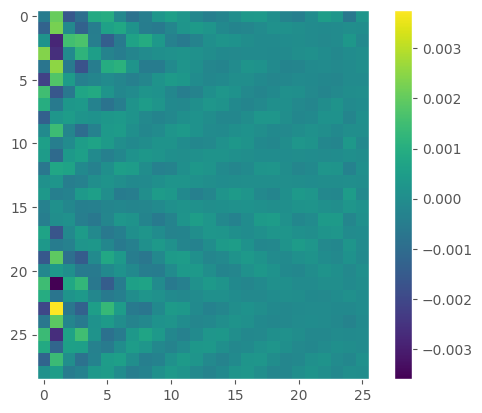

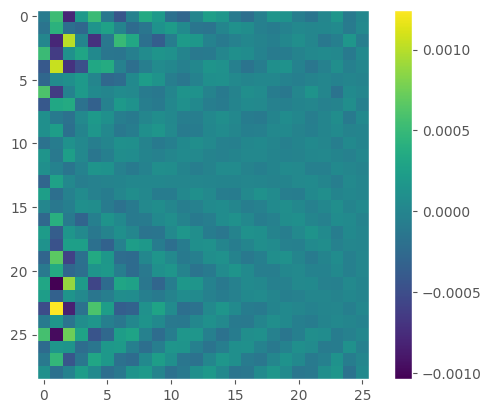

Pre Refinement  2.786873923051343e-07
Post Refinement  3.50569685683175e-08


In [330]:
equation_residuals = EqnModel.equation_residual(params)
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()

equation_residuals_refined = EqnModel.equation_residual(p_adjusted)
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

In [347]:
u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]

# u_sol = p_adjusted[:u_model.num_params]
# P_sol = p_adjusted[u_model.num_params:]

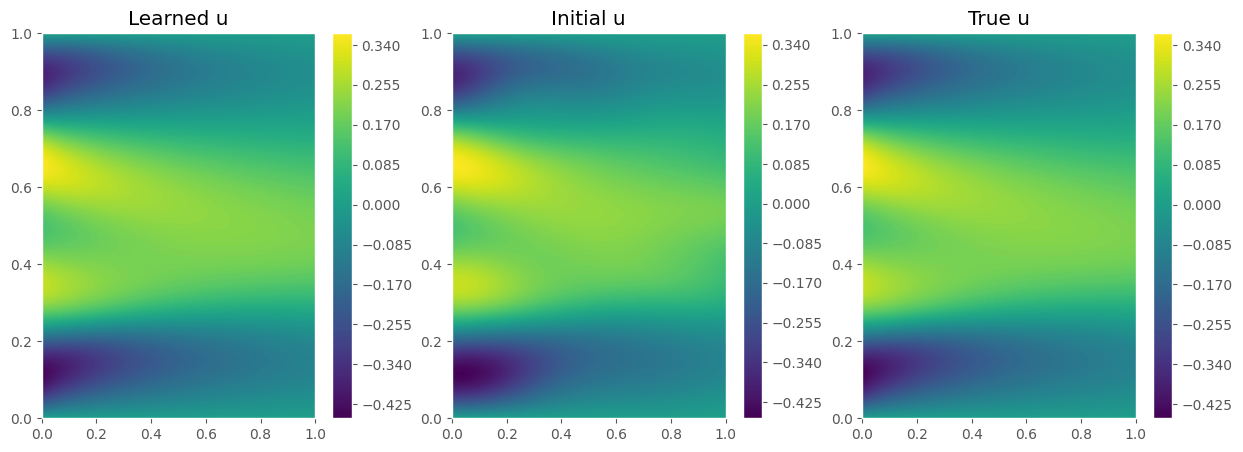

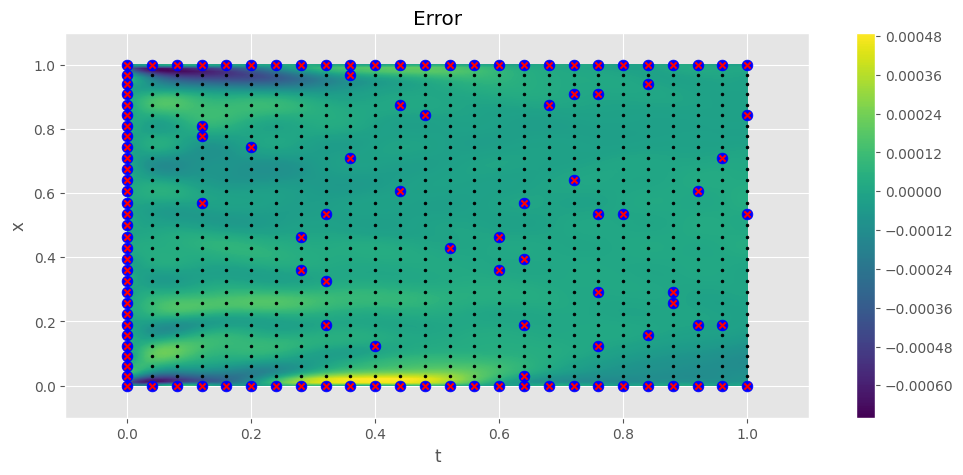

In [348]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Initial u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_model.point_evaluate(tx_grid_fine,u_params_init),200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.colorbar()

plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='blue',s = 60)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 20,marker = 'x')


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [349]:
def compare_values(x,y):
    plt.plot([np.min(x),np.max(x)],
            [np.min(x),np.max(x)],c = 'blue',lw = 0.8)
    plt.scatter(x,y,c = 'black',s = 4)


num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interp.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interp.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interp.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = u_model.evaluate_operators(feature_operators,tx_fine_int,u_params_init).reshape(len(tx_fine_int),len(feature_operators),order = 'F')
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

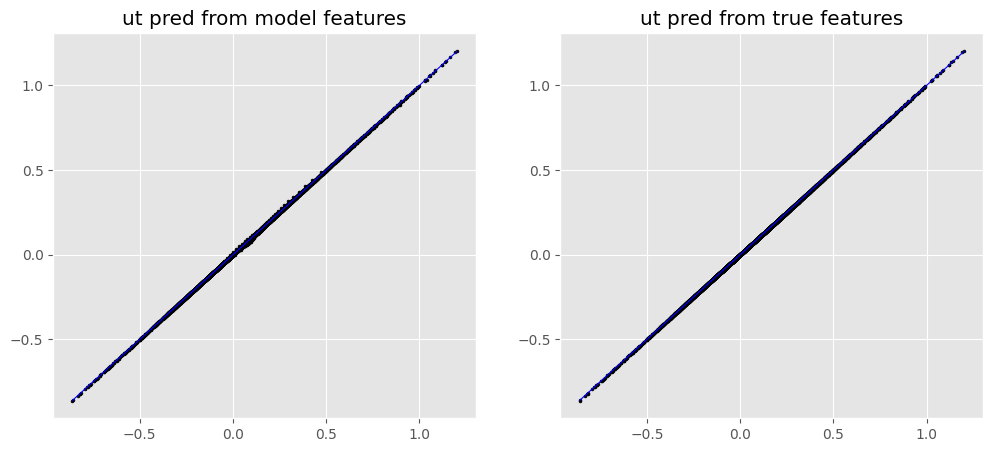

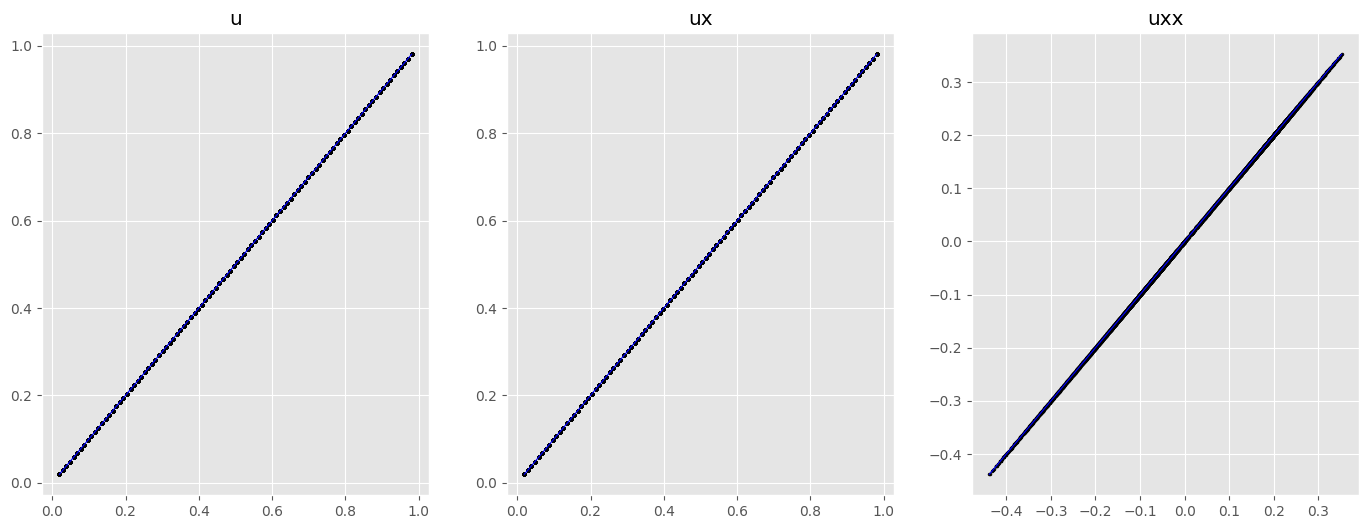

In [350]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,0],true_features[:,0])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,1],true_features[:,1])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,2],true_features[:,2])
plt.show()


In [351]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

def get_clipped_nrmse(true,pred, perc = 1):
    pred_clipped = jnp.clip(pred,jnp.percentile(pred,perc),jnp.percentile(pred,100-perc))
    true_clipped = jnp.clip(true,jnp.percentile(true,perc),jnp.percentile(true,100-perc))
    return get_nrmse(true_clipped,pred_clipped)


def get_nmae(true,pred):
    return jnp.mean(jnp.abs(true-pred))/jnp.mean(jnp.abs(true))

print("Normalized RMSE")
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

print("Clipped Normalized RMSE")
print("Optimized model feature predictions ",get_clipped_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_clipped_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features_init))


print("Normalized MAE")
print("Optimized model feature predictions ",get_nmae(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nmae(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nmae(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nmae(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nmae(ut_true,P_preds_init_model_features_init))

Normalized RMSE
Optimized model feature predictions  0.005969395408463644
Optimized true feature predictions  0.0023582682174753565
2 step model feature predictions  0.2863709698400128
2 step true feature predictions  0.28661011773505296
2 step init model feature predictions  26528.594099174505
Clipped Normalized RMSE
Optimized model feature predictions  0.006128008285178707
Optimized true feature predictions  0.002299631037089266
2 step model feature predictions  0.27763082599987254
2 step true feature predictions  0.2778806900642777
2 step init model feature predictions  26858.75516162306
Normalized MAE
Optimized model feature predictions  0.0028056094803060694
Optimized true feature predictions  0.0018604427256774707
2 step model feature predictions  0.2863584029748255
2 step true feature predictions  0.28665122417137795
2 step init model feature predictions  17832.864894870894


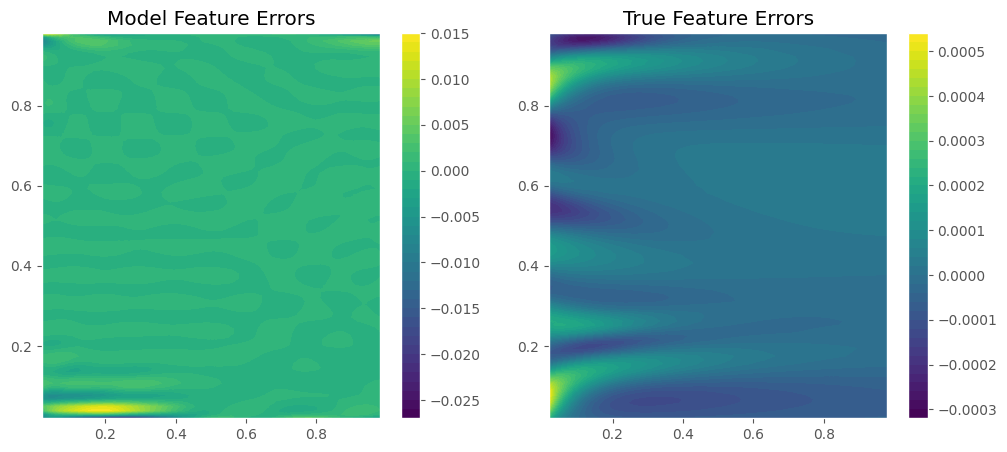

In [336]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Model Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,50,)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_true_features,50,)
plt.colorbar()

plt.show()

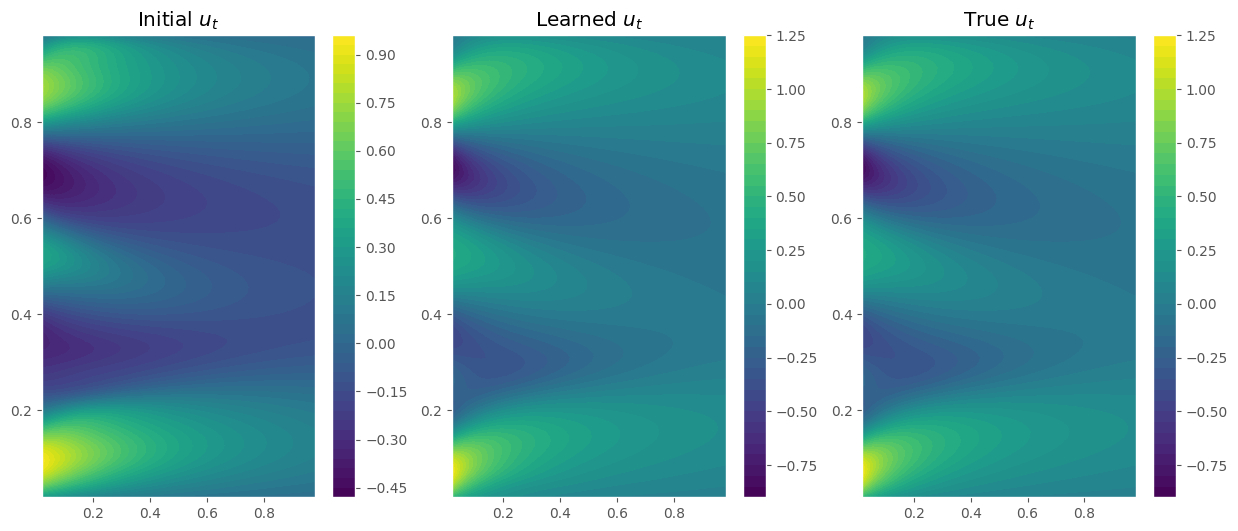

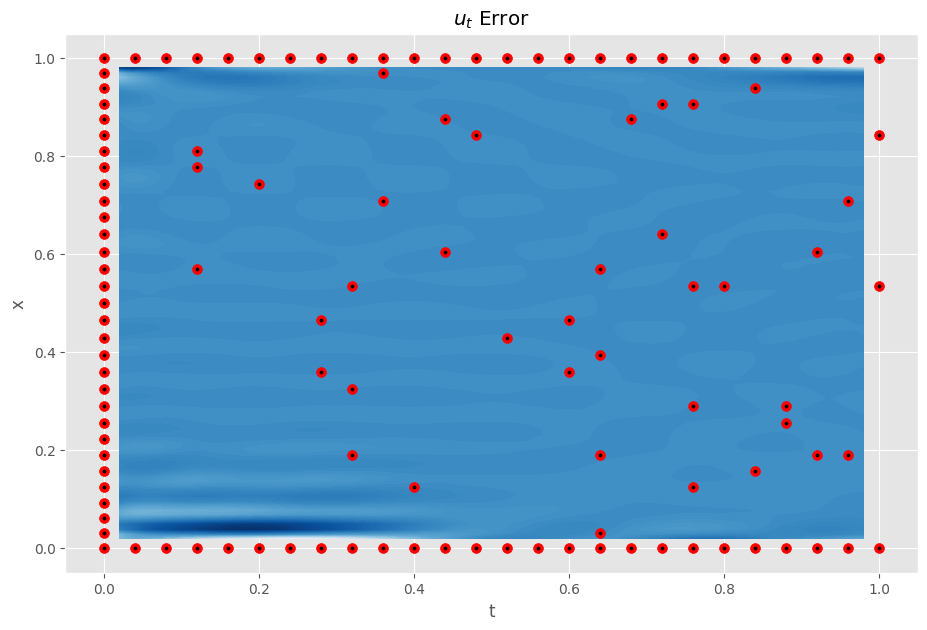

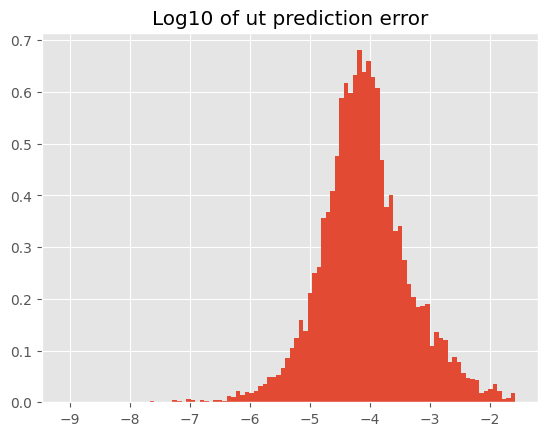

In [337]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

  0%|          | 0/2019 [00:00<?, ?it/s]

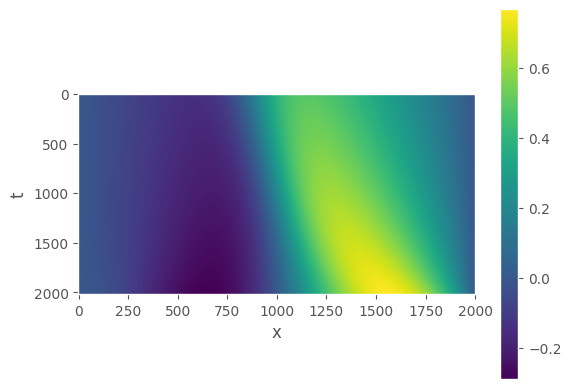

In [338]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def new_func_u0(x):
    u0 = -1 * x * jnp.sin(2 * jnp.pi * x)
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0_new = new_func_u0(grid)[1:-1]

sols_new,tvals = solver(u0_new,1.01)
sols_new = np.hstack([np.zeros((len(sols_new),1)),sols_new,np.zeros((len(sols_new),1))])

new_interp = RectBivariateSpline(tvals,grid,sols_new)
def new_u_true_function(x):
    return new_interp(x[:,0],x[:,1],grid = False)


plt.imshow(sols_new[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [339]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 50.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators((dt_k,),tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [340]:
new_u_init = 0*u_sol

u_params_pde,loss_vals_pde,JtRes_pde,improvement_ratios_pde,alpha_vals_pde,iterate_history_pde = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)
u_pde_adj,refinement_losses_pde,reg_vals_pde = adaptive_refine_solution(u_params_pde,PdeModel,1e-5,150)


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.05561, Jres = 156.7, alpha = 0.04167, improvement_ratio = 0.9992
Iteration 1, loss = 0.003936, Jres = 0.3099, alpha = 0.03472, improvement_ratio = 0.9293
Iteration 2, loss = 9.861e-06, Jres = 0.07408, alpha = 0.02894, improvement_ratio = 0.9984
Iteration 3, loss = 2.967e-06, Jres = 0.0009865, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 2.622e-06, Jres = 1.032e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 2.38e-06, Jres = 8.643e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 1.572e-06, Jres = 5.123e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 8.236e-07, Jres = 2.175e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.754e-07, Jres = 1.213e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 1.057e-07, Jres = 3.428e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.368e-08, Jres = 7.581e-08, alpha = 4.579e-06, improvement_ratio = 1.0
I

  0%|          | 0/150 [00:00<?, ?it/s]

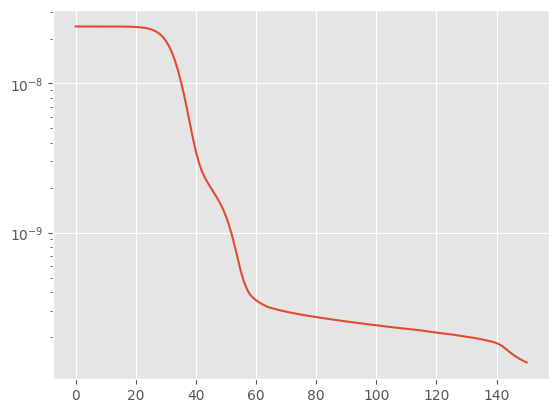

In [341]:
plt.plot(refinement_losses_pde)
plt.yscale('log')

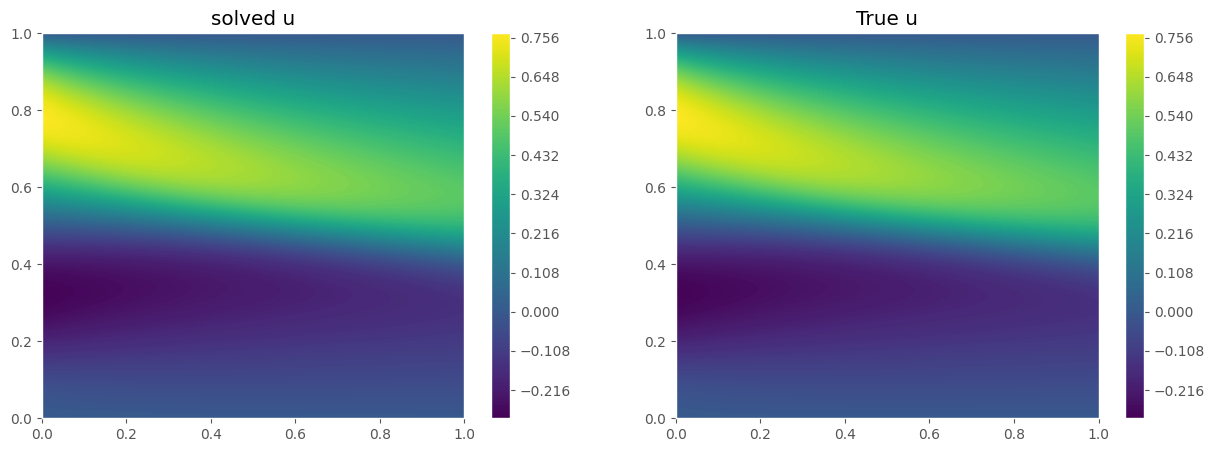

In [342]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

new_u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_params_pde)

new_u_true_fine = new_u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("solved u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_eval_fine,200)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine,200)
plt.colorbar()


Text(0.5, 1.0, 'Error')

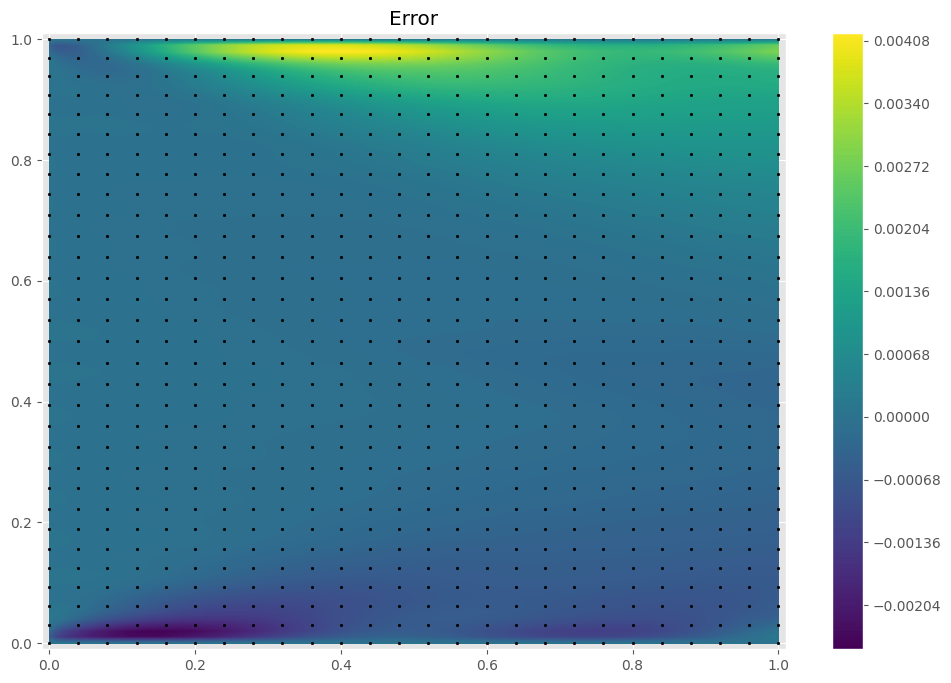

In [343]:
plt.figure(figsize=(12,8))
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],s = 3,c='black')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.title("Error")

In [344]:
jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine))

Array(0.0041456, dtype=float64)

In [345]:
get_nrmse(new_u_true_fine,new_u_eval_fine)

Array(0.00220749, dtype=float64)

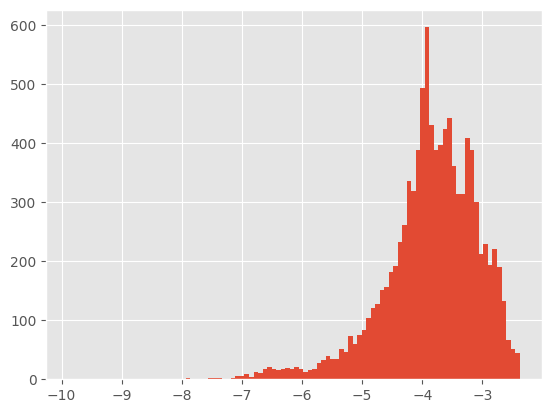

In [346]:
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()